In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
VERBOSE = 0  # constant for debugging, higher number means more printing
TRAIN_VAL_SPLIT = 6  # number of train files per task, the rest for validation
DOWNSAMPLING_FACTOR = 10
DIR = ''  # Directory of Intra/Cross directories

In [3]:
def log(message: tuple, verbose_true: int, verbose_min):
    """Helper print function, based on verbose params."""
    if verbose_true >= verbose_min:
        for entry in message:
            print(entry, end=' ')
        print()

In [4]:
def load_data(filename):
    """Load data from .h5 file."""
    with h5py.File(filename, 'r') as f:
        data = f[next(iter(f.keys()))][()]
    return data

In [5]:
def data_loader(input_dir: str) -> tuple[np.ndarray, str]:
    """Generator for loading data and its filename from all .h5 files in a directory."""
    for file in os.listdir(input_dir):
        if not file.endswith('.h5'):
            continue
        path = os.path.join(input_dir, file)
        data = load_data(path)
        yield data, file

In [6]:
def create_data_file(data, output_dir, filename: str):
    """Create .h5 file with given data."""
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    with h5py.File(output_path, 'w') as f:
        f.create_dataset(filename.rsplit('.', 1)[0], data=data)

In [7]:
def get_file_info(filename: str) -> tuple[str, int, int]:
    """Extract information from the file name."""
    filename = filename.rsplit('.', 1)[0].split('_')
    task, person_id, window = filename[-3], filename[-2], filename[-1]
    return task, int(window), int(person_id)

### Preprocessing

In [8]:
def downsample(data, factor):
    """Downsample data based on factor."""
    return decimate(data, factor, axis=1)

In [9]:
def get_means(data) -> np.ndarray:
    """Get means for every sensor dimension."""
    return np.mean(data, axis=1, keepdims=True)

In [10]:
def get_stds(data) -> np.ndarray:
    """Get standard deviations for every sensor dimension."""
    return np.std(data, axis=1, keepdims=True)

In [11]:
def z_score_normalize(data, means, stds):
    """Z-score normalization for every sensor dimension."""
    return (data - means) / stds

In [12]:
def downsample_and_save(input_dir, output_dir, factor, verbose):
    """Downsample data in each file and save them in a new file."""
    for data, file in data_loader(input_dir):
        data = downsample(data, factor)
        create_data_file(data, output_dir, f"ds_{file}")

In [13]:
def normalize_and_save(input_dir, output_dir, means, stds, verbose):
    """Normalize data in each file and save them in a new file."""
    for data, file in data_loader(input_dir):
        data = z_score_normalize(data, means, stds)
        create_data_file(data, output_dir, f"norm_{file}")

In [14]:
def concat_together(input_dir, train_val_split=TRAIN_VAL_SPLIT):
    """
    Concatenate data from files into a single time window of sensor readings.
    Also split to a train and validation sets.
    """
    train_data = None
    val_data = None
    for data, file in data_loader(input_dir):
        _, window, _ = get_file_info(file)
        if window <= train_val_split and train_data is None:
            train_data = data
        elif window <= train_val_split:
            train_data = np.concat((train_data, data), axis=1)
        elif val_data is None:
            val_data = data
        else:
            val_data = np.concat((train_data, data), axis=1)
    return train_data, val_data

In [15]:
def concat_as_samples(input_dir, train_val_split=TRAIN_VAL_SPLIT):
    """
    Concatenate data from files, treating each data file as a window sample
    of sensor readings. Also split them to train and validation sets.
    """
    samples_train = []
    tasks_train = []
    ids_train = []
    samples_val = []
    tasks_val = []
    ids_val = []
    for data, file in data_loader(input_dir):
        task, window, person_id = get_file_info(file)
        if window <= train_val_split:
            samples_train.append(data)
            tasks_train.append(task)
            ids_train.append(person_id)
        else:
            samples_val.append(data)
            tasks_val.append(task)
            ids_val.append(person_id)
    if not samples_val:
        return np.stack(samples_train), tasks_train
    return np.stack(samples_train), tasks_train, ids_train, np.stack(samples_val), tasks_val, ids_val

In [18]:
downsample_and_save(f'{DIR}Intra/train', f'{DIR}Intra/train_ds', DOWNSAMPLING_FACTOR, VERBOSE)
downsample_and_save(f'{DIR}Cross/train', f'{DIR}Cross/train_ds', DOWNSAMPLING_FACTOR, VERBOSE)

### t-SNE Data Visualization

In [49]:
def make_tsne(X_train, y_train, ids_train, X_val, y_val, ids_val):
    # Flatten data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    print(np.shape(X_train_flat))

    # Combine train and val for visualization
    X_combined = np.vstack([X_train_flat, X_val_flat])
    labels_combined = y_train + y_val
    ids_combined = ids_train + ids_val

    # Optional: PCA first for speed
    X_combined_pca = PCA(n_components=10).fit_transform(X_combined)

    # t-SNE
    tsne = TSNE(n_components=2, perplexity=5)
    X_tsne = tsne.fit_transform(X_combined_pca)

    return X_tsne, labels_combined, ids_combined

In [53]:
def plot_tsne(X_tsne, labels_combined, ids_combined):
    plt.figure(figsize=(8, 6))
    subjects = list(set(ids_combined))
    markers = ['o', 's']

    for label in set(labels_combined):
        for i, subject in enumerate(subjects):
            idx = [j for j, (l, s) in enumerate(zip(labels_combined, ids_combined))
                   if l == label and s == subject]
            plt.scatter(
                X_tsne[idx, 0], X_tsne[idx, 1],
                label=f"{label.capitalize()}, Subject {subject}",
                alpha=0.7,
                marker=markers[i % len(markers)],
                edgecolors='k'  # Optional: black edge for contrast
            )

    plt.legend()
    plt.title("t-SNE visualization of MEG samples")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

(24, 248, 3563)
(8, 248, 3563)
['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'math', 'math', 'math', 'math', 'math', 'math', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory']
(24, 883624)


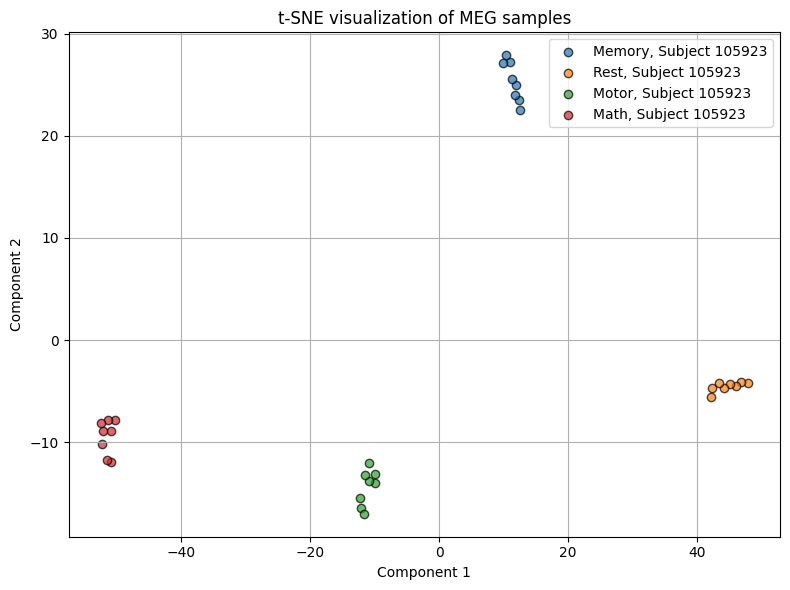

In [54]:
data_train, _ = concat_together(f'{DIR}Intra/train_ds')
means, stds = get_means(data_train), get_stds(data_train)
normalize_and_save(f'{DIR}Intra/train_ds', f'{DIR}Intra/train_ds_norm', means, stds, VERBOSE)
data_train, labels_train, ids_train, data_val, labels_val, ids_val = \
    concat_as_samples(f'{DIR}Intra/train_ds_norm')
print(np.shape(data_train))
print(np.shape(data_val))
print(labels_train)

tsne, labels, ids = make_tsne(data_train, labels_train, ids_train, data_val, labels_val, ids_val)
plot_tsne(tsne, labels, ids)

(48, 248, 3563)
(16, 248, 3563)
['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory']
(48, 883624)


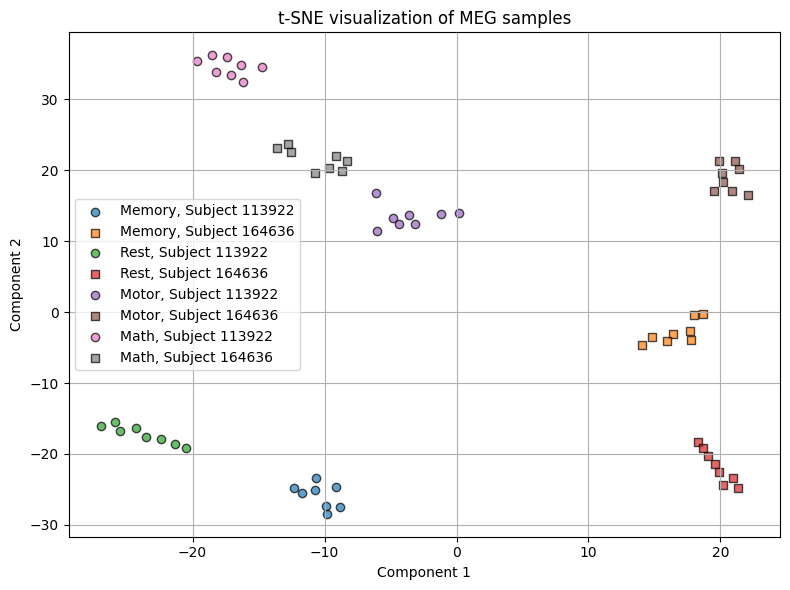

In [56]:
cr_data_train, _ = concat_together(f'{DIR}Cross/train_ds')
cr_means, cr_stds = get_means(cr_data_train), get_stds(cr_data_train)
normalize_and_save(f'{DIR}Cross/train_ds', f'{DIR}Cross/train_ds_norm', cr_means, cr_stds, VERBOSE)
cr_data_train, cr_labels_train, cr_ids_train, cr_data_val, cr_labels_val, cr_ids_val \
    = concat_as_samples(f'{DIR}Cross/train_ds_norm')
print(np.shape(cr_data_train))
print(np.shape(cr_data_val))
print(cr_labels_train)

tsne, labels, ids = make_tsne(
    cr_data_train, cr_labels_train, cr_ids_train, cr_data_val, cr_labels_val, cr_ids_val
)
plot_tsne(tsne, labels, ids)

#### Multiclass Logistic Regression

In [60]:
def prepare_data(X_train, y_train, X_val, y_val):
    # Flatten the data
    X_train_flat = X_train.reshape(len(X_train), -1)
    X_val_flat = X_val.reshape(len(X_val), -1)
    print(np.shape(X_train_flat))

    # Encode string labels to integers
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    print(y_train)
    print(y_val)

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_val_tensor = torch.tensor(X_val_flat, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    return X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor

In [61]:
class MulticlassLogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MulticlassLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)  # No softmax here; CrossEntropyLoss does it

In [62]:
def train_lr(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)

        if (epoch + 1) % 1 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

In [88]:
def evaluate_model(model, X_eval_tensor, y_eval_tensor):
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_eval_tensor)
        print(val_outputs)
        _, val_predictions = torch.max(val_outputs, 1)
        print('True classes     :', y_eval_tensor)
        print('Model predictions:', val_predictions)
        matches = val_predictions == y_eval_tensor
        accuracy = matches.float().mean()
        print(f'Validation Accuracy: {accuracy.item():.4f}')

#### Logistic Regression on Intra Dataset

In [89]:
data_train, _ = concat_together(f'{DIR}Intra/train_ds')
means, stds = get_means(data_train), get_stds(data_train)
normalize_and_save(f'{DIR}Intra/train_ds', f'{DIR}Intra/train_ds_norm', means, stds, VERBOSE)
data_train, labels_train, _, data_val, labels_val, _ = \
    concat_as_samples(f'{DIR}Intra/train_ds_norm')
X_train, y_train, X_val, y_val = prepare_data(data_train, labels_train, data_val, labels_val)
model = MulticlassLogisticRegression(X_train.shape[1], len(set(labels_train)))
train_lr(model, X_train, y_train, X_val, y_val, num_epochs=3, lr=0.01)
evaluate_model(model, X_val, y_val)

(24, 883624)
[3 3 3 3 3 3 2 2 2 2 2 2 0 0 0 0 0 0 1 1 1 1 1 1]
[3 3 2 2 0 0 1 1]
Epoch 1/3, Train Loss: 1.6603, Val Loss: 0.0000
Epoch 2/3, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 3/3, Train Loss: 0.0000, Val Loss: 0.0000
tensor([[-34916.3242, -21126.8535, -32688.9395,  39808.1953],
        [-38562.7812, -22744.3184, -37429.9922,  44175.8359],
        [  6005.5928,   3692.0815,  15386.8301, -11139.1797],
        [  6288.2271,   4548.2456,  15673.1826, -11580.3271],
        [ 11813.7324,    603.2658,   3430.4832,  -8696.4570],
        [ 11851.0205,   1310.9561,   3160.3965,  -8951.1084],
        [  3471.4346,   9213.7471,  -2179.0405,  -3950.1755],
        [  3092.6499,   8448.5684,  -2208.0503,  -3434.1748]])
True classes     : tensor([3, 3, 2, 2, 0, 0, 1, 1])
Model predictions: tensor([3, 3, 2, 2, 0, 0, 1, 1])
Validation Accuracy: 1.0000


#### Logistic Regression on Cross Dataset

In [90]:
cr_data_train, _ = concat_together(f'{DIR}Cross/train_ds')
cr_means, cr_stds = get_means(cr_data_train), get_stds(cr_data_train)
normalize_and_save(f'{DIR}Cross/train_ds', f'{DIR}Cross/train_ds_norm', cr_means, cr_stds, VERBOSE)
cr_data_train, cr_labels_train, _, cr_data_val, cr_labels_val, _ = \
    concat_as_samples(f'{DIR}Cross/train_ds_norm')
X_train, y_train, X_val, y_val = prepare_data(cr_data_train, cr_labels_train, cr_data_val, cr_labels_val)
model = MulticlassLogisticRegression(X_train.shape[1], len(set(cr_labels_train)))
train_lr(model, X_train, y_train, X_val, y_val, num_epochs=10, lr=0.00001)
evaluate_model(model, X_val, y_val)

(48, 883624)
[3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1]
[3 3 3 3 2 2 2 2 0 0 0 0 1 1 1 1]
Epoch 1/10, Train Loss: 1.4949, Val Loss: 0.3591
Epoch 2/10, Train Loss: 0.3633, Val Loss: 0.1723
Epoch 3/10, Train Loss: 0.1438, Val Loss: 0.0877
Epoch 4/10, Train Loss: 0.0524, Val Loss: 0.0517
Epoch 5/10, Train Loss: 0.0210, Val Loss: 0.0326
Epoch 6/10, Train Loss: 0.0096, Val Loss: 0.0216
Epoch 7/10, Train Loss: 0.0050, Val Loss: 0.0149
Epoch 8/10, Train Loss: 0.0028, Val Loss: 0.0107
Epoch 9/10, Train Loss: 0.0017, Val Loss: 0.0079
Epoch 10/10, Train Loss: 0.0011, Val Loss: 0.0061
tensor([[-62.3009, -56.1168, -74.7760,  94.4192],
        [-69.5079, -63.6124, -83.9150, 106.1340],
        [-28.2869,  -9.3665, -36.1667,  41.3350],
        [-31.3180, -12.6385, -41.0935,  47.1611],
        [-12.8618,   0.5014,  42.1106,   0.7677],
        [  2.7383,   2.3865,  27.1404, -13.2999],
        [  6.0641,  10.9438,  17.1120, -16.6168],
        [  5.

### EEGnet

In [16]:
class EEGConvNet(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super(EEGConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.act3 = nn.ReLU()
        self.pool3 = nn.AdaptiveAvgPool1d(output_size=1)

        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [22]:
def train_eegnet(train_loader, val_loader, num_classes, num_epochs=10, lr=1e-3, testing=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EEGConvNet(in_channels=248, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)

        if testing is False:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item() * X_batch.size(0)
                    _, preds = torch.max(outputs, dim=1)
                    matches = preds == y_batch
                    correct += matches.sum().item()
                    total += y_batch.size(0)
            epoch_val_loss = val_loss / len(val_loader.dataset)
            val_accuracy = correct / total
            scheduler.step()
            print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {epoch_train_loss:.4f},  Val Loss: {epoch_val_loss:.4f},  Val Acc: {val_accuracy:.4f}")

    model.eval()
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            if testing is False:
                print(outputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_trues.append(y_batch.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_trues = torch.cat(all_trues, dim=0)
    matches = all_preds == all_trues
    final_acc = matches.float().mean().item()
    print(f"\nFinal Evaluation Accuracy: {final_acc:.4f}")
    print("True classes     :", all_trues)
    print("Model predictions:", all_preds)
    return model

In [23]:
def evaluate_eegnet(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_trues = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_trues.append(y_batch.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_trues = torch.cat(all_trues, dim=0)
    matches = all_preds == all_trues
    final_acc = matches.float().mean().item()
    print(f"\nFinal Evaluation Accuracy: {final_acc:.4f}")
    print("True classes     :", all_trues)
    print("Model predictions:", all_preds)

In [18]:
def get_dataloaders(X_train, y_train, X_val, y_val, batch_size=16):
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    num_classes = len(le.classes_)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    val_ds = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, num_classes

#### EEGnet on Intra dataset

In [128]:
data_train, _ = concat_together(f'{DIR}Intra/train_ds')
means, stds = get_means(data_train), get_stds(data_train)
normalize_and_save(f'{DIR}Intra/train_ds', f'{DIR}Intra/train_ds_norm', means, stds, VERBOSE)
data_train, labels_train, _, data_val, labels_val, _ = \
    concat_as_samples(f'{DIR}Intra/train_ds_norm')
train_loader, val_loader, num_classes = get_dataloaders(data_train, labels_train, data_val, labels_val)
train_eegnet(train_loader, val_loader, num_classes, num_epochs=10, lr=1e-3)

Epoch 1/10  Train Loss: 1.1807,  Val Loss: 1.0261,  Val Acc: 1.0000
Epoch 2/10  Train Loss: 0.3573,  Val Loss: 0.6508,  Val Acc: 1.0000
Epoch 3/10  Train Loss: 0.1541,  Val Loss: 0.3913,  Val Acc: 1.0000
Epoch 4/10  Train Loss: 0.1138,  Val Loss: 0.2139,  Val Acc: 1.0000
Epoch 5/10  Train Loss: 0.0545,  Val Loss: 0.1174,  Val Acc: 1.0000
Epoch 6/10  Train Loss: 0.0344,  Val Loss: 0.0659,  Val Acc: 1.0000
Epoch 7/10  Train Loss: 0.0389,  Val Loss: 0.0375,  Val Acc: 1.0000
Epoch 8/10  Train Loss: 0.0760,  Val Loss: 0.0211,  Val Acc: 1.0000
Epoch 9/10  Train Loss: 0.0454,  Val Loss: 0.0143,  Val Acc: 1.0000
Epoch 10/10  Train Loss: 0.0459,  Val Loss: 0.0090,  Val Acc: 1.0000
tensor([[-1.9678, -2.0905, -2.0646,  5.5730],
        [-2.1293, -2.2599, -2.2643,  6.0744],
        [-2.2235, -2.4203,  5.0666, -2.7073],
        [-2.1474, -2.2760,  4.9109, -2.7016],
        [ 4.7060, -2.7062, -1.3229, -2.3605],
        [ 4.4315, -2.4917, -1.3149, -2.2395],
        [-1.4219,  3.3866, -1.6483, -1.1834

#### EEGnet on Cross dataset with normal data split

In [95]:
cr_data_train, _ = concat_together(f'{DIR}Cross/train_ds')
cr_means, cr_stds = get_means(cr_data_train), get_stds(cr_data_train)
normalize_and_save(f'{DIR}Cross/train_ds', f'{DIR}Cross/train_ds_norm', cr_means, cr_stds, VERBOSE)
cr_data_train, cr_labels_train, _, cr_data_val, cr_labels_val, _ = \
    concat_as_samples(f'{DIR}Cross/train_ds_norm')
train_loader, val_loader, num_classes = \
    get_dataloaders(cr_data_train, cr_labels_train, cr_data_val, cr_labels_val)
train_eegnet(train_loader, val_loader, num_classes, num_epochs=10, lr=1e-3)

Epoch 1/10  Train Loss: 1.1359,  Val Loss: 1.0911,  Val Acc: 0.6250
Epoch 2/10  Train Loss: 0.5417,  Val Loss: 0.7431,  Val Acc: 0.9375
Epoch 3/10  Train Loss: 0.1980,  Val Loss: 0.4338,  Val Acc: 1.0000
Epoch 4/10  Train Loss: 0.1413,  Val Loss: 0.2228,  Val Acc: 1.0000
Epoch 5/10  Train Loss: 0.0802,  Val Loss: 0.1103,  Val Acc: 1.0000
Epoch 6/10  Train Loss: 0.0828,  Val Loss: 0.0577,  Val Acc: 1.0000
Epoch 7/10  Train Loss: 0.0455,  Val Loss: 0.0338,  Val Acc: 1.0000
Epoch 8/10  Train Loss: 0.0357,  Val Loss: 0.0197,  Val Acc: 1.0000
Epoch 9/10  Train Loss: 0.0541,  Val Loss: 0.0105,  Val Acc: 1.0000
Epoch 10/10  Train Loss: 0.0423,  Val Loss: 0.0070,  Val Acc: 1.0000
tensor([[-2.2048, -0.6337, -1.8759,  4.8370],
        [-2.4941, -0.6700, -2.0826,  5.3674],
        [-2.6726, -0.9389, -2.1628,  5.3306],
        [-2.9089, -1.0152, -2.3392,  5.7920],
        [-6.3241, -2.4802,  8.9081, -4.7650],
        [-3.6436, -1.5556,  5.6763, -3.3497],
        [-2.5235, -2.0425,  5.1806, -2.9391

#### EEGnet on Cross dataset with one subject for training and one subject for validation

In [30]:
def concat_together_one_subject(input_dir):
    """
    Concatenate data of ONE SUBJECT ONLY from files
    into a single time window of sensor readings.
    """
    subject_data = None
    subject_id = None
    for data, file in data_loader(input_dir):
        _, _, person_id = get_file_info(file)
        if subject_id is None and subject_data is None:
            subject_data = data
            subject_id = person_id
        elif person_id == subject_id:
            subject_data = np.concat((subject_data, data), axis=1)
    return subject_data

In [31]:
def concat_as_samples_subject_split(input_dir):
    """
    Concatenate data from files, treating each data file as a window sample
    of sensor readings. Split data of one subject to train set and data of the other
    subject(s) to validation set.
    """
    samples_train = []
    tasks_train = []
    id_train = None
    samples_val = []
    tasks_val = []
    for data, file in data_loader(input_dir):
        task, window, person_id = get_file_info(file)
        if id_train is None:
            samples_train.append(data)
            tasks_train.append(task)
            id_train = person_id
        elif id_train == person_id:
            samples_train.append(data)
            tasks_train.append(task)
        else:
            samples_val.append(data)
            tasks_val.append(task)
    return np.stack(samples_train), tasks_train, np.stack(samples_val), tasks_val

In [32]:
cr_data_train = concat_together_one_subject(f'{DIR}Cross/train_ds')
cr_means, cr_stds = get_means(cr_data_train), get_stds(cr_data_train)
normalize_and_save(f'{DIR}Cross/train_ds', f'{DIR}Cross/train_ds_norm', cr_means, cr_stds, VERBOSE)
cr_data_train, cr_labels_train, cr_data_val, cr_labels_val = \
    concat_as_samples_subject_split(f'{DIR}Cross/train_ds_norm')
print(len(cr_data_train), len(cr_data_val))
print(cr_labels_train)
print(cr_labels_val)

32 32
['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory']
['rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'motor', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'math', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory', 'memory']


In [69]:
train_loader, val_loader, num_classes = \
    get_dataloaders(cr_data_train, cr_labels_train, cr_data_val, cr_labels_val)
train_eegnet(train_loader, val_loader, num_classes, num_epochs=25, lr=1e-4)

Epoch 1/25  Train Loss: 1.5979,  Val Loss: 1.3952,  Val Acc: 0.4375
Epoch 2/25  Train Loss: 1.3564,  Val Loss: 1.3971,  Val Acc: 0.1250
Epoch 3/25  Train Loss: 1.1097,  Val Loss: 1.3985,  Val Acc: 0.1250
Epoch 4/25  Train Loss: 1.0441,  Val Loss: 1.3982,  Val Acc: 0.1250
Epoch 5/25  Train Loss: 0.7801,  Val Loss: 1.3963,  Val Acc: 0.1562
Epoch 6/25  Train Loss: 0.7678,  Val Loss: 1.3924,  Val Acc: 0.4062
Epoch 7/25  Train Loss: 0.6388,  Val Loss: 1.3870,  Val Acc: 0.5000
Epoch 8/25  Train Loss: 0.6009,  Val Loss: 1.3804,  Val Acc: 0.5000
Epoch 9/25  Train Loss: 0.6254,  Val Loss: 1.3743,  Val Acc: 0.5000
Epoch 10/25  Train Loss: 0.3807,  Val Loss: 1.3692,  Val Acc: 0.5000
Epoch 11/25  Train Loss: 0.3080,  Val Loss: 1.3673,  Val Acc: 0.5000
Epoch 12/25  Train Loss: 0.3238,  Val Loss: 1.3670,  Val Acc: 0.5000
Epoch 13/25  Train Loss: 0.2958,  Val Loss: 1.3691,  Val Acc: 0.5000
Epoch 14/25  Train Loss: 0.2941,  Val Loss: 1.3747,  Val Acc: 0.5000
Epoch 15/25  Train Loss: 0.2664,  Val Loss:

EEGConvNet(
  (conv1): Conv1d(248, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (pool3): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)

### Evaluation of EEGnet on Intra Test set

In [129]:
downsample_and_save(f'{DIR}Intra/test', f'{DIR}Intra/test_ds', DOWNSAMPLING_FACTOR, VERBOSE)

In [19]:
data_train, _ = concat_together(f'{DIR}Intra/train_ds', train_val_split=100)
means, stds = get_means(data_train), get_stds(data_train)
normalize_and_save(f'{DIR}Intra/train_ds', f'{DIR}Intra/train_ds_norm', means, stds, VERBOSE)
normalize_and_save(f'{DIR}Intra/test_ds', f'{DIR}Intra/test_ds_norm', means, stds, VERBOSE)
data_train, labels_train = concat_as_samples(f'{DIR}Intra/train_ds_norm', train_val_split=100)
data_test, labels_test = concat_as_samples(f'{DIR}Intra/test_ds_norm', train_val_split=100)

train_loader, val_loader, num_classes = get_dataloaders(data_train, labels_train, data_test, labels_test)
train_eegnet(train_loader, val_loader, num_classes, num_epochs=10, lr=1e-3, testing=True)


Final Evaluation Accuracy: 1.0000
True classes     : tensor([3, 3, 2, 2, 0, 0, 1, 1])
Model predictions: tensor([3, 3, 2, 2, 0, 0, 1, 1])


### Evaluation of EEGnet on Cross Test set

In [20]:
downsample_and_save(f'{DIR}Cross/test1', f'{DIR}Cross/test1_ds', DOWNSAMPLING_FACTOR, VERBOSE)
downsample_and_save(f'{DIR}Cross/test2', f'{DIR}Cross/test2_ds', DOWNSAMPLING_FACTOR, VERBOSE)
downsample_and_save(f'{DIR}Cross/test3', f'{DIR}Cross/test3_ds', DOWNSAMPLING_FACTOR, VERBOSE)

In [21]:
data_train, _ = concat_together(f'{DIR}Cross/train_ds', train_val_split=100)
means, stds = get_means(data_train), get_stds(data_train)

normalize_and_save(f'{DIR}Cross/train_ds', f'{DIR}Cross/train_ds_norm', means, stds, VERBOSE)
normalize_and_save(f'{DIR}Cross/test1_ds', f'{DIR}Cross/test1_ds_norm', means, stds, VERBOSE)
normalize_and_save(f'{DIR}Cross/test2_ds', f'{DIR}Cross/test2_ds_norm', means, stds, VERBOSE)
normalize_and_save(f'{DIR}Cross/test3_ds', f'{DIR}Cross/test3_ds_norm', means, stds, VERBOSE)

In [66]:
data_train, labels_train = concat_as_samples(f'{DIR}Cross/train_ds_norm', train_val_split=100)
data_test, labels_test = concat_as_samples(f'{DIR}Cross/test1_ds_norm', train_val_split=100)

train_loader, val_loader, num_classes = get_dataloaders(data_train, labels_train, data_test, labels_test)
eeg_model = train_eegnet(train_loader, val_loader, num_classes, num_epochs=25, lr=1e-4, testing=True)


Final Evaluation Accuracy: 0.8750
True classes     : tensor([3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1])
Model predictions: tensor([3, 3, 3, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1])


In [67]:
data_test, labels_test = concat_as_samples(f'{DIR}Cross/test2_ds_norm', train_val_split=100)
_, val_loader, _ = get_dataloaders(data_train, labels_train, data_test, labels_test)
evaluate_eegnet(eeg_model, val_loader)


Final Evaluation Accuracy: 0.2500
True classes     : tensor([3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1])
Model predictions: tensor([3, 3, 3, 3, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0])


In [68]:
data_test, labels_test = concat_as_samples(f'{DIR}Cross/test3_ds_norm', train_val_split=100)
_, val_loader, _ = get_dataloaders(data_train, labels_train, data_test, labels_test)
evaluate_eegnet(eeg_model, val_loader)


Final Evaluation Accuracy: 0.8125
True classes     : tensor([3, 3, 3, 3, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1])
Model predictions: tensor([3, 3, 3, 3, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1])
